In [1]:
from config import API_KEY
import requests

In [14]:
BASE_URL="https://maps.googleapis.com/maps/api/"
def makeRequest(url):
    url+="&key=%s"%API_KEY
    #print(url)
    return requests.get(url).json()
def getDistanceMatrix(origin,destination,mode="car",departure_time=None,traffic_model ="best_guess"):
    url=BASE_URL+"distancematrix/json?"
    params="origins=%s&destinations=%s&mode=%s&departure_time=%s&traffic_model=%s"%(origin,destination,mode,departure_time,traffic_model)
    return makeRequest(url+params)

In [15]:
import datetime
departure_time=datetime.datetime.now().timestamp()
response=getDistanceMatrix("60607","60527","car",int(departure_time))
response

{'destination_addresses': ['Willowbrook, IL 60527, USA'],
 'origin_addresses': ['Chicago, IL 60607, USA'],
 'rows': [{'elements': [{'distance': {'text': '32.5 km', 'value': 32453},
     'duration': {'text': '28 mins', 'value': 1691},
     'duration_in_traffic': {'text': '32 mins', 'value': 1946},
     'status': 'OK'}]}],
 'status': 'OK'}

TODO add optimistic and pessimistic range. Compute for range until a point. E.g. I need to be home by 6 and want the least time driving

In [16]:
len(range(0,60*20,15))*3

240

In [89]:
now=datetime.datetime(2017, 6, 21, 12, 45, 0, 0)

In [91]:
from collections import defaultdict
departure_time=datetime.datetime(2017, 6, 21, 12, 45, 0, 0)#datetime.datetime.now()
start_date=departure_time
request_times=defaultdict(dict)
for date in (start_date + datetime.timedelta(minutes=offset) for offset in range(0,60*8,15)):
    #if date<start_date+datetime.timedelta(hours=5):#replace with UNTIL
    date_str=date#.strftime("%b-%d %H:%M")
    request_times['best_guess'][date_str]=(getDistanceMatrix("60606","60527","car",int(date.timestamp()),'best_guess'))
    request_times['pessimistic'][date_str]=(getDistanceMatrix("60606","60527","car",int(date.timestamp()),'pessimistic'))
    request_times['optimistic'][date_str]=(getDistanceMatrix("60606","60527","car",int(date.timestamp()),'optimistic'))

In [92]:
request_times_copy=request_times.copy()
for date in request_times_copy:
    for traffic_model in request_times_copy[date]:
        request_times_copy[date][traffic_model]=request_times[date][traffic_model]['rows'][0]['elements'][0]['duration_in_traffic']['value']

In [93]:
import pandas as pd
travel_times=pd.DataFrame(request_times_copy)/60
travel_times.tail()

,best_guess,optimistic,pessimistic
2017-06-21 19:30:00,28.716667,25.483333,35.45
2017-06-21 19:45:00,28.000000,25.016667,34.65
2017-06-21 20:00:00,27.900000,24.983333,34.20
2017-06-21 20:15:00,28.033333,24.966667,34.55
2017-06-21 20:30:00,27.883333,24.983333,34.25


In [67]:
travel_times.to_csv("travel_times.csv")

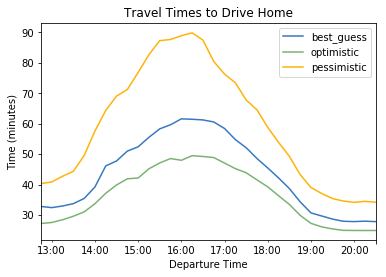

In [134]:
import matplotlib.pyplot as plt
%matplotlib inline
colors=['xkcd:windows blue','xkcd:faded green','xkcd:amber',]
travel_times.plot(color=colors)
plt.title("Travel Times to Drive Home")
plt.xlabel("Departure Time")
plt.ylabel("Time (minutes)")

Adding in latest time to leave

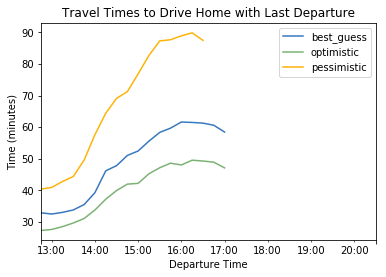

In [135]:
#probably a pandas function I could use here but this was easier
ARRIVE_BY=datetime.datetime(2017, 6, 21, 18, 0, 0, 0)
new_rows=[]
for time,row in travel_times.iterrows():
    new_row=[]
    for val in row:
        new_val=None
        if time+datetime.timedelta(minutes=val)<=ARRIVE_BY:
            new_val=val
        new_row.append(new_val)
    new_rows.append(new_row)
new_travel_times=pd.DataFrame(new_rows, columns=travel_times.columns, index=travel_times.index)
new_travel_times.plot(color=colors)
plt.title("Travel Times to Drive Home with Last Departure")
plt.xlabel("Departure Time")
plt.ylabel("Time (minutes)")

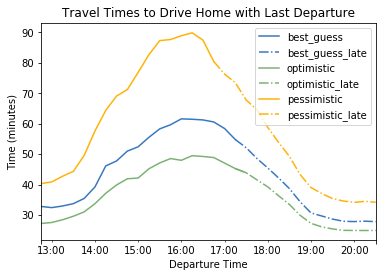

In [259]:
#probably a pandas function I could use here but this was easier
ARRIVE_BY=datetime.datetime(2017, 6, 21, 18, 0, 0, 0)
new_rows=[]
for time,row in travel_times.iterrows():
    new_row={}
    for col,val in row.items():
        if time+datetime.timedelta(minutes=val)<=ARRIVE_BY:
            new_row[col]=val
            new_row[col+"_late"]=None
        elif time+datetime.timedelta(minutes=val-15)<=ARRIVE_BY:
            new_row[col]=val
            new_row[col+"_late"]=val
        else:
            new_row[col+"_late"]=val
            new_row[col]=None
    new_rows.append(new_row)
new_travel_times=pd.DataFrame(new_rows,index=travel_times.index)
new_colors=[x for x in colors for _ in range(2)]
new_travel_times.plot(color=new_colors,style=['-','-.','-','-.','-','-.'])
plt.title("Travel Times to Drive Home with Last Departure")
plt.xlabel("Departure Time")
plt.ylabel("Time (minutes)")

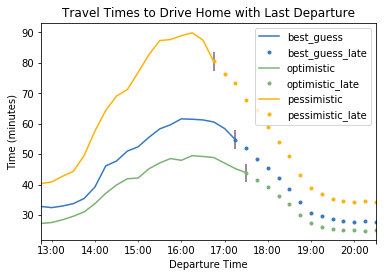

In [257]:
from collections import defaultdict
ARRIVE_BY=datetime.datetime(2017, 6, 21, 18, 1,0, 0)#have a small off by one error below
v_lines=defaultdict(tuple)
new_rows=[]
for time,row in travel_times.iterrows():
    new_row={}
    for col,val in row.items():
        if time+datetime.timedelta(minutes=val)<=ARRIVE_BY:
            new_row[col]=val
            new_row[col+"_late"]=None
        elif time+datetime.timedelta(minutes=val-15)<=ARRIVE_BY:
            if v_lines[col]==():
                v_lines[col]=[time,val-3,val+3]
            new_row[col]=val
            new_row[col+"_late"]=val
        else:
            new_row[col+"_late"]=val
            new_row[col]=None
    new_rows.append(new_row)
new_travel_times=pd.DataFrame(new_rows,index=travel_times.index)
new_colors=[x for x in colors for _ in range(2)]
new_travel_times.plot(color=new_colors,style=['-','.','-','.','-','.'])
for key,vline in v_lines.items():
    plt.vlines(x=vline[0],  ymin=vline[1], ymax=vline[2],color="xkcd:dusty purple")
plt.title("Travel Times to Drive Home with Last Departure")
plt.xlabel("Departure Time")
plt.ylabel("Time (minutes)")

In [253]:
new_travel_times

,best_guess,best_guess_late,optimistic,optimistic_late,pessimistic,pessimistic_late
2017-06-21 12:45:00,32.866667,NaN,27.266667,NaN,40.366667,NaN
2017-06-21 13:00:00,32.483333,NaN,27.600000,NaN,40.916667,NaN
2017-06-21 13:15:00,33.016667,NaN,28.500000,NaN,42.783333,NaN
2017-06-21 13:30:00,33.783333,NaN,29.650000,NaN,44.383333,NaN
2017-06-21 13:45:00,35.483333,NaN,31.083333,NaN,49.600000,NaN
2017-06-21 14:00:00,39.266667,NaN,33.766667,NaN,57.616667,NaN
2017-06-21 14:15:00,46.166667,NaN,37.183333,NaN,64.400000,NaN
2017-06-21 14:30:00,47.800000,NaN,39.916667,NaN,69.100000,NaN
2017-06-21 14:45:00,51.033333,NaN,41.950000,NaN,71.233333,NaN
2017-06-21 15:00:00,52.450000,NaN,42.200000,NaN,76.866667,NaN
